## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Spring 2021.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw CIFAR-100 data.
label_map, X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers
In this part, all the functions will be created from scratch using numpy for better understanding. (In the next task, you will be introduced to built in layers from TensorFlow.)

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [3]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function: H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check your implementation using the tf.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation results
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.


<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [4]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)

## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [5]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,20)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,20))
    loss_tf = tf.reduce_mean(cross_entropy)
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [6]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [7]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: Two Layer Network

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [8]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=20, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype = tf.float32)
y_tf = tf.Variable(y_dev, dtype = tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf))
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,20))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 

loss_check=loss_tf.numpy()
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [9]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [10]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=500, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 31.928563294096655
10000/49000 loss: 6.014412823193133
15000/49000 loss: 3.2939073903886595
20000/49000 loss: 3.0804125706295893
25000/49000 loss: 3.040564514983703
30000/49000 loss: 2.8898869442398043
35000/49000 loss: 2.8760959216385436
40000/49000 loss: 2.868406761949738
45000/49000 loss: 2.863774186041676
epoch 1: valid acc = 0.133, new learning rate = 0.000475
5000/49000 loss: 2.805593341620045
10000/49000 loss: 2.795655387058252
15000/49000 loss: 2.741632533794411
20000/49000 loss: 2.784022895781062
25000/49000 loss: 2.7174004501715423
30000/49000 loss: 2.7678662727513577
35000/49000 loss: 2.7318274541939127
40000/49000 loss: 2.739965368747198
45000/49000 loss: 2.6713355936229024
epoch 2: valid acc = 0.174, new learning rate = 0.00045125
5000/49000 loss: 2.652868914423127
10000/49000 loss: 2.634708903074987
15000/49000 loss: 2.6644302198911847
20000/49000 loss: 2.599968178900936
25000/49000 loss: 2.6652183481029854
30000/49000 l

0.2835

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

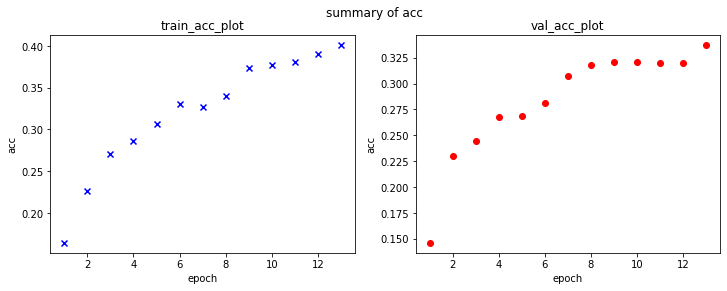

In [19]:
## TODO: plot the accuracy history

from matplotlib import pyplot as plt 

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(range(1,11), train_acc_hist, marker='x',color='blue')
ax[1].scatter(range(1,11), val_acc_hist, color='red');
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('acc'), ax[1].set_ylabel('acc')
ax[0].set_title('train_acc_plot')
ax[1].set_title('val_acc_plot')
fig.suptitle('summary of acc');

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [12]:
from utils.display_funcs import visualize_pics

num of feature vectors: 500


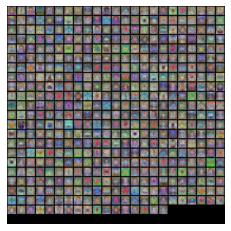

In [13]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 35%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 35%. If your accuracy is lower, for each 1% lower than 35%, you will lose 1 point (There are totally 10 points for this part).

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [14]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to the code below, using your parameter specs:
model = TwoLayerNet(input_dim=3072, hidden_dim=800, num_classes=20, reg=1e-4, weight_scale=1e-3)
num_epoch = 13
batch_size = 300
lr = 6e-4
verbose = True

train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 163


/Users/jameszhao/Desktop/e4040/e4040-2021spring-assign1-xz2987/utils/layer_funcs.py:181: RuntimeWarning: divide by zero encountered in log
  loss = np.sum( -np.log(softmax_matrix[np.arange(N), y]) )


3000/49000 loss: 52.65452924285187
6000/49000 loss: 4.373330813732319
9000/49000 loss: 3.107159021504145
12000/49000 loss: 3.003717828220176
15000/49000 loss: 2.9875623795360826
18000/49000 loss: 3.004962319395494
21000/49000 loss: 3.015185709358075
24000/49000 loss: 2.9333096071127436
27000/49000 loss: 2.947876011264486
30000/49000 loss: 2.9191645255072505
33000/49000 loss: 2.914862368060378
36000/49000 loss: 2.8755844327224844
39000/49000 loss: 2.8534627047576775
42000/49000 loss: 2.8128886832153768
45000/49000 loss: 2.76621442829424
48000/49000 loss: 2.741004645696728
epoch 1: valid acc = 0.146, new learning rate = 0.000588
3000/49000 loss: 2.744580213254465
6000/49000 loss: 2.716294237642583
9000/49000 loss: 2.67467704427095
12000/49000 loss: 2.638556151474914
15000/49000 loss: 2.5997659860094084
18000/49000 loss: 2.5800306429694566
21000/49000 loss: 2.5519759095246957
24000/49000 loss: 2.614447822488424
27000/49000 loss: 2.5975764997727806
30000/49000 loss: 2.5958081913060673
3300

39000/49000 loss: 2.1283002969341687
42000/49000 loss: 1.9430463649460534
45000/49000 loss: 2.049908980001547
48000/49000 loss: 2.0379594269731585
epoch 13: valid acc = 0.337, new learning rate = 0.00046141343355606234
test acc: 0.3426


0.3426

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

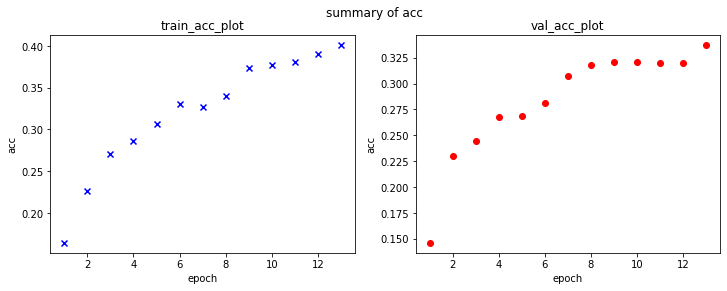

In [20]:
## TODO: plot training and validation accuracy

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(range(1,14), train_acc_hist, marker='x',color='blue')
ax[1].scatter(range(1,14), val_acc_hist, color='red');
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('acc'), ax[1].set_ylabel('acc')
ax[0].set_title('train_acc_plot')
ax[1].set_title('val_acc_plot')
fig.suptitle('summary of acc');

num of feature vectors: 800


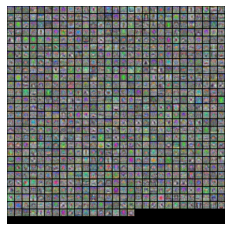

In [21]:
## TODO: Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [22]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## Load your model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Network

Complete the class **MLP** in **./utils/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [23]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                          #

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 100
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490


0.3273

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

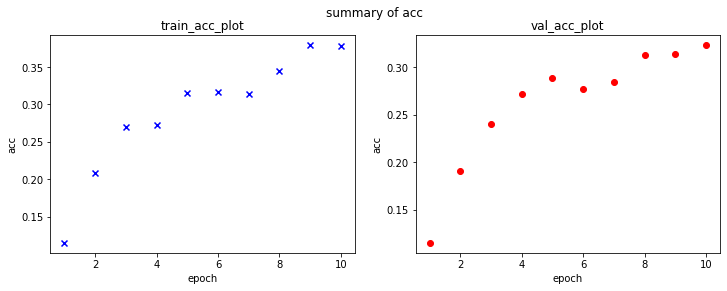

In [24]:
#TODO: plot training and validation accuracy
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(range(1,11), train_acc_hist, marker='x',color='blue')
ax[1].scatter(range(1,11), val_acc_hist, color='red');
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('acc'), ax[1].set_ylabel('acc')
ax[0].set_title('train_acc_plot')
ax[1].set_title('val_acc_plot')
fig.suptitle('summary of acc');